<a href="https://colab.research.google.com/github/Toldry/CATegorizer/blob/main/CATegorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

We are Alon Eitan and Dor Daniel, students in the Open University of Israel.

In this project, we aim to create an image classification model for cat subreddits in the social media website Reddit.

Since we both never had a project with computer vision and we thought that this project is a great opportunity try somting new, plus Alon's love for cats and reddit and cats on reddit was unparalleled. His affection won Dor over so we decided to try to classify as many subreddit as posibile.

##The problem

 Reddit is a social media platform ,and its structure is a network of communities on people's interests. 
Its main use is sharing content for the people to see on a subreddits.

A subreddit is a specific online community that focuses on a topic, like cars , sports, coding problems and in our case: cats or onlyhappycats or CatsWithHats and even HistoricalCatLovers.

Our objective is to create a model that gets a picture of a cat as input, and outputs which subreddit(s) the picture fits the best. 

For example, if the model receives a picture of a [black cat wearing a hat](https://i.redd.it/f0brl1wvs6v51.jpg), then it may suggest that the picture fits in r/BlackCats and r/CatsWithHats.

Then, after the model is complete, we'll create a bot u/CATegorizer_bot, that automatically replies to cat pictures and gives suggestions to which cat subreddits it might fit best.

We know that our data set is too broad but still we want to try and see what can we do with it and what unexpected results we can discover. 

We plan to try a different ways to so, some of them include the libraries TensorFlow,Keras and ImageAI.

# Challenges

## Intersectionality
There is a large intersection between the content that can be found in different subreddits. For instance, [this picture](https://i.redd.it/0cj4wyr1uc851.jpg) could be appropriately placed in any one of these subreddits:


* r/CatsOnKeyboards
* r/IllegallySmolCats
* r/tinyorangekittens
* r/Catswithjobs
* r/orangecats
* r/gingerkitty
* r/Cats

with the last subreddit r/Cats being truly all-encompassing.

It is therefore challenging to determine whether any particular picture not only fits a certain subreddit at all, but which of the subreddits that it does fit, are **most** fitting.


## Unrelated content
Despite reddit being neatly organized into different subreddits, each having a category of content that intuitively fits it, redditors often err and share content to a subreddit that doesn't strictly fit it's theme.

Other redditors who like the submission often choose to upvote it despite not fitting the theme of the subreddit, either because they didn't notice the mismatch or they simply don't care.

As a result, we find pictures of orange cats in r/BlackCats. This essentialy acts as mislabeled data for the purposes of our classification algorithm.


#Data collection

To collect the data, we wrote a scraper:
https://github.com/Toldry/CATegorizer/blob/main/scraper.py

It uses the Python library `praw`, to scans the top 1000 submissions of every cat subreddit.

The list `cat_subredditss.csv` was generated from the cat subreddit index:
https://www.reddit.com/r/Catsubs/wiki/index


The scraper first filtered the subreddits that are restricted or private or deleted, or had too few subscribers. The viable subreddits are in `filtered_cat_subs.csv`.

Each submission has many attributes related to it, most of which are irrelevant to our aim of classifying cat images. 
We arbitrarily chose the following attributes which we thought might be useful:
* id
* url
* permalink
* score
* title
* total_awards_received
* ups
* upvote_ratio
* is_original_content
* gilded
* num_comments
* num_crossposts
* num_duplicates
* over_18

The critical fields are `url` which links to the image, and `score` which shows how many people upvoted the submission.

The total number of submission we originally collected is 124,623. 

The scraper took roughly five days to collect all the data, not including the images themselves.

#Data cleanining


First we discarded all the posts with broken urls.
We leveraged the `concurrent.futures` multithreading library to accelrate the process of checking which urls are broken.

Without it it would have taken approximately 2 days to run, with it, it ran for only 4~5 hours.
Because the time to run was unknown we didnt run it in the notebook.

We exported the information of the broken urls to a .txt file so we could check some of the urls to see if they are broken before deleting them. 

We used 10 seconds for timeouts, luckily no timeouts occured.


In [ ]:
import requests
import pandas as pd
import numpy as np
import concurrent.futures
import urllib

In [ ]:
# def bad_url(a_url, an_index, timeout=10):
#     response = requests.get(url=a_url, timeout=timeout)
#     if response.status_code == 404:
#         #the plus 2 is for maching the index in df to the CSV file for easier confirmation
#         print(an_index + 2, 'ERROR')
#         return str(an_index + 2)
#     #the prining is for following the run
#     if (an_index % 2000 == 0 ):
#         print(an_index, ' done')
#     #when we returned noting or "" it bugd out
#     return " "


# if __name__ == '__main__':
#     f = open("broken_url.txt", "a",encoding="utf-8")
#     df = pd.read_csv('submission.csv')

#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = []
#         for x in df.index:
#             futures.append(executor.submit(bad_url, a_url=df.loc[x, "url"], an_index=x))
#         #run on completed Threads output
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 f.write(future.result())
#             except requests.ConnectTimeout:
#                 print("ConnectTimeout.")
#     f.close()


in total, 528 broken urls were detected.


#Exploratory data analaysis

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = [20, 10] # Increase the figure size across the entire notebook

In [ ]:
# Get the data

SUBMISSIONS_URL = 'https://raw.githubusercontent.com/Toldry/CATegorizer/main/submission.csv'
data = pd.read_csv(SUBMISSIONS_URL)
data = data.set_index('id')

data.describe()

,score,total_awards_received,ups,upvote_ratio,gilded,num_comments,num_crossposts,num_duplicates
count,125078.000000,125078.000000,125078.000000,125078.000000,125078.000000,125078.000000,125078.000000,125078.000000
mean,1169.404636,0.701099,1169.404636,0.980533,0.014983,13.913110,0.223349,0.465150
std,2568.936052,5.259843,2568.936052,0.042288,0.140240,35.995101,0.870128,1.663655
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,77.000000,0.000000,77.000000,0.980000,0.000000,2.000000,0.000000,0.000000
50%,277.000000,0.000000,277.000000,0.990000,0.000000,5.000000,0.000000,0.000000
75%,982.000000,0.000000,982.000000,1.000000,0.000000,14.000000,0.000000,0.000000
max,71658.000000,522.000000,71658.000000,1.000000,12.000000,4054.000000,27.000000,51.000000


In [ ]:
data.columns

Index(['subreddit_name', 'url', 'permalink', 'score', 'title',
       'total_awards_received', 'ups', 'upvote_ratio', 'is_original_content',
       'gilded', 'num_comments', 'num_crossposts', 'num_duplicates',
       'over_18'],
      dtype='object')

In [ ]:
# Number of different subreddits:
len(data['subreddit_name'].unique())

346

We'd also be wise to filter out any submission that doesn't have some minimum number of upvotes, because such submissions are less likely to be reliably relevant to their respective subreddit, or be relevant at all.

In [ ]:
MINIMUM_SCORE_THRESHOLD = 100
score_below_minimum = data['score'] < MINIMUM_SCORE_THRESHOLD
print(score_below_minimum.value_counts())

False    88158
True     36920
Name: score, dtype: int64


The most important value we can use to judge how "good" or "fitting the subreddit" a single submission is by looking at the number of **upvotes** it has.

In the dataset, this info is in the `score` column:

In [ ]:
grouped = data.groupby('subreddit_name')
result = grouped.agg({'score': ['mean', 'min', 'max']})
result = result.sort_values(('score', 'max'), ascending=False)
result['score']

,mean,min,max
subreddit_name,,,
Cats,19493.501269,15038,71658
Chonkers,10951.398252,6416,48697
Meow_Irl,10433.070857,6923,34105
CatsWhoYell,10596.463710,5831,33759
StartledCats,12587.205882,7307,29284
...,...,...,...
CatQueries,3.428571,0,9
FelineCare,3.550000,1,6
CatsFailingJumps,6.000000,6,6


Let's take a look at the number of upvotes each subreddit's most upvoted submission has:

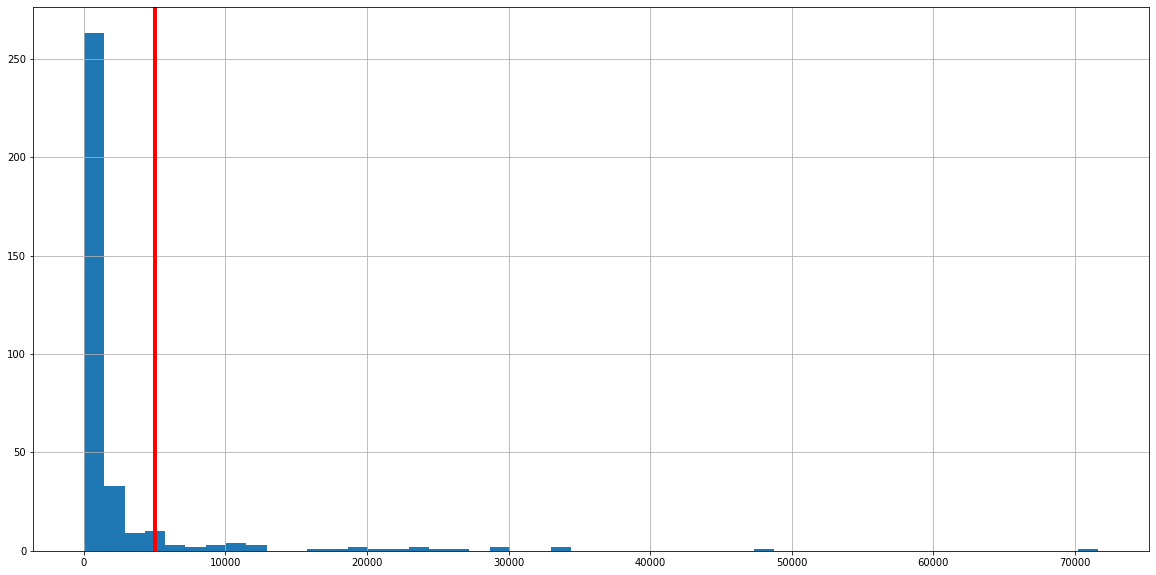

In [ ]:
result2 = result[('score', 'max')]
result2 = result['score']['max']
result2.hist(bins=50)
plt.axvline(5000, color='r', linewidth=4)

The vast majority of subreddit's most upvoted submission has a score that is below 5000. (Left of the red line)

Let's take a more granular look at those subreddits:

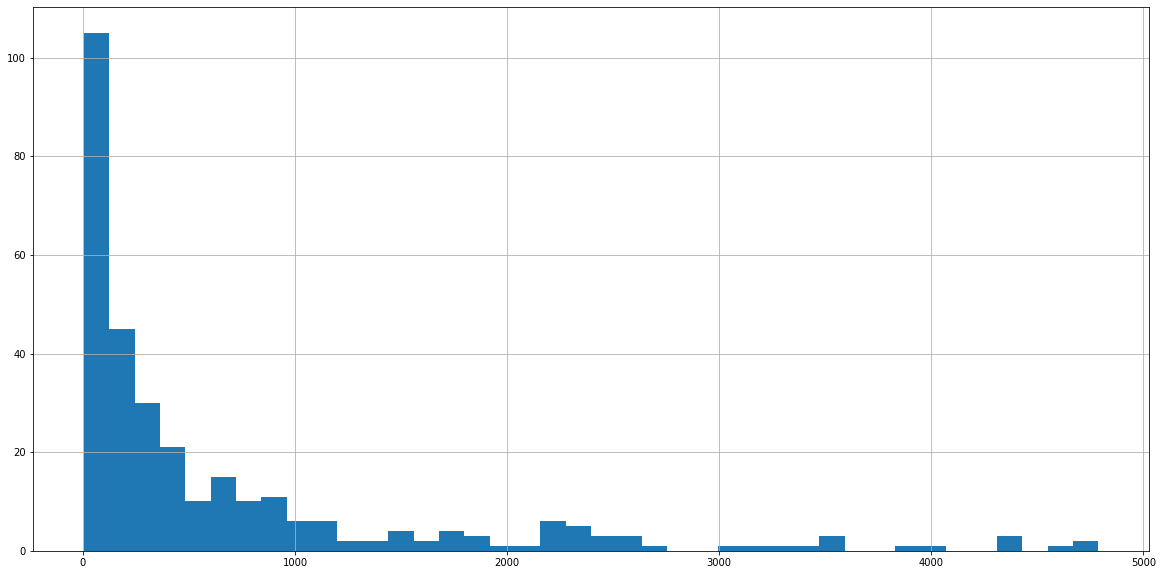

In [ ]:
result3 = result2[result2 < 5000]
result3.hist(bins=40)

When the top submission has fewer than 1000 upvotes, it indicates that the subreddit is not very popular. 

In [ ]:
SUBREDDIT_MINIMUM_SCORE_THRESHOLD = 1000

subreddits_below_minimum_threshold = result2 < SUBREDDIT_MINIMUM_SCORE_THRESHOLD

print(subreddits_below_minimum_threshold.value_counts())

True     248
False     98
Name: max, dtype: int64


## Numerical fields

In [ ]:
numerical_classes = ['score', 'total_awards_received', 'ups', 'upvote_ratio', 'gilded', 'num_comments', 'num_crossposts', 'num_duplicates']
df2 = data[numerical_classes]
normalized = ((df2 - df2.mean()) / df2.std())
normalized

,score,total_awards_received,ups,upvote_ratio,gilded,num_comments,num_crossposts,num_duplicates
id,,,,,,,,
kodzf7,-0.292107,0.056827,-0.292107,0.460346,-0.106836,0.446919,-0.256685,-0.279595
lwk2qq,-0.328698,0.056827,-0.328698,0.223875,-0.106836,-0.080931,-0.256685,-0.279595
clcd2p,-0.344658,-0.133293,-0.344658,0.460346,-0.106836,-0.275402,0.892572,0.321491
goit9q,-0.350886,-0.133293,-0.350886,0.460346,-0.106836,-0.247620,-0.256685,0.321491
kxctgx,-0.354390,-0.133293,-0.354390,0.223875,-0.106836,-0.247620,-0.256685,-0.279595
...,...,...,...,...,...,...,...,...
pdaon,-0.452096,-0.133293,-0.452096,0.460346,-0.106836,-0.358746,-0.256685,0.321491
pda5i,-0.452096,-0.133293,-0.452096,0.460346,-0.106836,-0.386528,-0.256685,-0.279595
pkxou,-0.452096,-0.133293,-0.452096,0.460346,-0.106836,-0.386528,-0.256685,-0.279595


In [ ]:
# This takes a long time (> 2 min) to execute
#pd.plotting.scatter_matrix(normalized)

In [ ]:
import seaborn as sns
# This takes a long time (>13 min) to execute
# sns.heatmap(normalized, cmap="YlGnBu", annot=True)

##Binary Fields

The dataset includes only two binary fields: `is_original_content` and `over_18`

In [ ]:
print(data['is_original_content'].value_counts())

False    124857
True        221
Name: is_original_content, dtype: int64


It well known by redditors that the majority of the posts in reddit are reposts, meaning that they are not original content.

However, it is surprisng to see that such a tiny fraction 221/124857 $\approx$ 0.001 of posts are marked as "original content".

Upon closer inspection, the `is_original_content` field appears to be [a rarely-used feature accessible only to moderators](https://www.reddit.com/r/redesign/comments/8a48uv/moderators_try_marking_posts_as_oc_on_the_redesign/), which explains why there are so few posts that are marked as OC.




In [ ]:
print(data['over_18'].value_counts())

False    124287
True        791
Name: over_18, dtype: int64


The `over_18` flag, also known as the "NSFW" flag (not safe for work) is used by both users and moderators to mark content that may contain nudity, intense sexuality, political incorrectness, profanity, slurs, violence or other potentially disturbing subject matter 

Seeing as our subject matter is cats, it makes sense that very few posts in our data are marked as `over_18`.



Since both flags don't contribute almost at all to the data, we can safely drop both of them.

In [ ]:
columns_to_remove = ['is_original_content', 'over_18']

## Text fields

The only text field in the dataset is `title`.

One venue to explore may be to use NLP techniques to extract useful information from title of the submission.

For now, we'll look at the simplest feature: length

       subreddit_name                                  url  ... over_18  title_len
id                                                          ...                   
kodzf7        catsubs  https://i.redd.it/eog5205syq861.jpg  ...   False         53
lwk2qq        catsubs  https://i.redd.it/8mcvaqsxfqk61.jpg  ...   False         94
clcd2p        catsubs      https://i.imgur.com/427vpjE.jpg  ...   False         19
goit9q        catsubs  https://i.redd.it/d20yl18pcb051.jpg  ...   False         32
kxctgx        catsubs  https://i.redd.it/qdhnttwqncb61.jpg  ...   False         81
...               ...                                  ...  ...     ...        ...
pdaon   onlyhappycats         http://i.imgur.com/GbeFh.jpg  ...   False         43
pda5i   onlyhappycats         http://i.imgur.com/3BMBI.jpg  ...   False         22
pkxou   onlyhappycats         http://i.imgur.com/vwlFr.jpg  ...   False         33
5l1ole  onlyhappycats   https://i.redd.it/y2qi5d0t0n6y.jpg  ...   False         41
poik

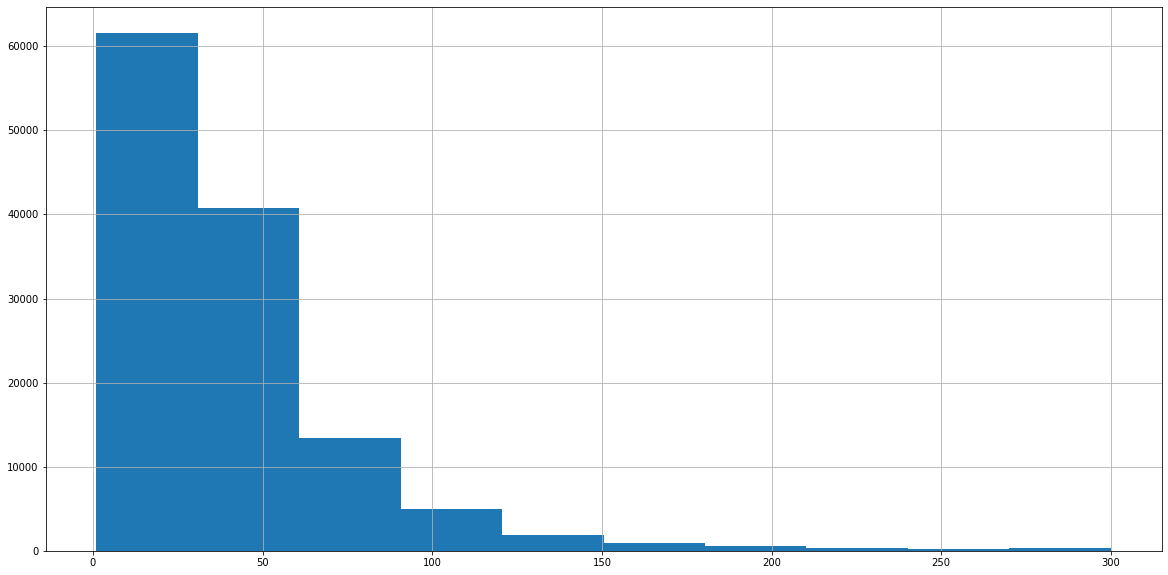

In [ ]:
data['title_len'] = data['title'].str.len()
numerical_classes += ['title_len']
data['title_len'].hist()
print(data)

Reddit's 300 character limit is apparent from this graph.

##Other Fields

`score` and `ups` are the same field:


In [ ]:
(data['score'] - data['ups']).value_counts()

0    125078
dtype: int64

Therefore we can drop the `ups` field.

In [ ]:
columns_to_remove += ['ups']

`upvote_ratio` is a field that was used in the past , reddit decided to stop using it without official information 
https://www.reddit.com/r/Enhancement/wiki/faq/uppers_downers_removed

`gilded` and `total_awards_received` are both bought with money , and they could be exploited. 
we could not find any relevent information frome both of them.

we belive that the fields `num_comments`,`num_crossposts`,`num_duplicates` may have some correlation to the success chance of the model so we will check it in the future 

##Principal Component Analaysis

###Alon

In [ ]:
import cv2
import glob
import pathlib

from sklearn.decomposition import PCA
pca = PCA(n_components=6)

img_height = 180
img_width = 180

targets = []
images = []

#github test

for filename in glob.glob('images/*'):
  subreddit = pathlib.PurePath(filename).name
  for imfile in glob.glob(filename + '/*.*'):
    img = cv2.imread(imfile)
    try:
      res = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    except:
      continue
    res = np.array(res).flatten()
    res = res/255
    images += [res]
    targets += [subreddit]



pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(images)

colors = []
color_map = {'BattleCats': 'red', 'SphynxCats': 'yellow', 'blackcats': 'black', 'TardCat': 'purple'}
for t in targets:
  colors += [color_map[t]]

# projected = projected[0:10]
# colors = colors[0:10]

print(projected)
print(colors)

plt.scatter(projected[:, 0], projected[:, 1],
            c=colors, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')

ValueError: ignored

**לסיים לנסות להריץ את הדומא של דור ובתקווה להשוות בין התוצעות במקרה ולא עובד למחוק**

In [ ]:
#https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371
dor_frame = pd.DataFrame(images)

fig, axes = plt.subplots(10,10,figsize=(9,9),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(dor_frame.iloc[i].values.reshape(180,180),cmap='gray')

In [ ]:
rom sklearn.decomposition import PCA
#n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
faces_pca = PCA(n_components=0.8)
faces_pca.fit(faces)
fig, axes = plt.subplots(2,10,figsize=(9,3),
 subplot_kw={‘xticks’:[], ‘yticks’:[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(dor_frame.components_[i].reshape(112,92),cmap=”gray”)

In [ ]:
components = faces_pca.transform(dor_frame)
projected = faces_pca.inverse_transform(components)
fig, axes = plt.subplots(10,10,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(112,92),cmap="gray")

**סוף דוגמא של דור לא לשכוח לשנות שמות של פנים לחתולים**

In [ ]:
df2 = data[numerical_classes]
print(numerical_classes)
normalized = ((df2 - df2.mean()) / df2.std())
normalized

In [ ]:
#Code example taken from https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
Principal_components=pca.fit_transform(normalized)
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])
print(pca.components_)
print('#'*90)
print(pca.explained_variance_)
print('#'*90)
print(pca_df)

In [ ]:
# Reset index necessary for the concat to work with the same shaped datasets
pca_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

for_visual = pd.concat([pca_df, data['subreddit_name']], axis = 1)
print(for_visual)

In [ ]:
#for_visual = for_visual.groupby('subreddit_name').mean()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Plot of 1st Two Principal Components vs. Subreddit', fontsize = 20)
W_GROUP = ['1st 33%','2nd 33%','3rd 33%']
colors = ['navy', 'turquoise', 'darkorange']
# for WINS_GROUP, color in zip(W_GROUP,colors):
#     indicesToKeep = for_visual['WINS_GROUP'] == WINS_GROUP
#     ax.scatter(for_visual.loc[indicesToKeep, 'PC 1']
#                , for_visual.loc[indicesToKeep, 'PC 2']
#                , c = color
#                , s = 50)
ax.scatter(for_visual.loc[:, 'PC 1']
            , for_visual.loc[:, 'PC 2']
            , s = 50)
# ax.legend(W_GROUP)
ax.grid()

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

The "elbow" of the plot is clearly at $n=2$ principal components

### Image PCA

In [ ]:
import cv2 as cv
from PIL import Image
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from numpy import asarray

cwd = os.getcwd()

data_dir = cwd + '/images'

#image_list = pd.DataFrame([])
image_list = []
image_suffixes = ['png', 'jpg', 'jpeg']


i = 0
for filename in glob.glob(data_dir + '/*/*.*'): 
    im=cv.imread(filename)
    try:
      cat = pd.Series(im.flatten(),name=filename)
    except:
      continue
    image_list.append(cat)
    i+=1
    if i==1000: break

image_fream=pd.DataFrame(image_list)

fig, axes = plt.subplots(10,10,figsize=(9,9),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
  print(image_list,i)
  ax.imshow(image_fream.iloc[i].values.reshape(112,92))



# Filteration

We filter the following rows:
* Duplicates
* Broken urls
* Score below minimum threshold (`score_below_minimum`)
* Submissions belonging to subreddits with top post which has a score below minmum threshold (`subreddits_below_minimum_threshold`)

and the following columns:
* is_original_content
* over_18
* upvote_ratio

In [ ]:
#after resting index set it again
data = pd.read_csv(SUBMISSIONS_URL)
data = data.set_index('id')
data3 = data.drop_duplicates()
print(f'Duplicates removed: {len(data) - len(data3)}')

index_to_delete = []
BROKEN_URLS = 'https://raw.githubusercontent.com/Toldry/CATegorizer/main/broken_url_by_id.txt'
with urllib.request.urlopen(BROKEN_URLS) as file:
  for line in file:
    decoded_line = line.decode('utf-8')
    decoded_line = decoded_line[0:-1] # remove newline
    index_to_delete += [decoded_line]

print(data)
data4 = data3.drop(index_to_delete)
print(f'Broken url rows removed: {len(data3)- len(data4)}')


data5 = data4.drop((data4[data4['score'] < MINIMUM_SCORE_THRESHOLD]).index)
print(f'Score below minimum threshold rows removed: {len(data4)- len(data5)}')


subreddits_to_delete = list(subreddits_below_minimum_threshold[subreddits_below_minimum_threshold == True].index)
data6 = data5.drop(data5[data5['subreddit_name'].isin(subreddits_to_delete)].index)

print(f'Subreddit below minimum threshold, rows removed: {len(data5)- len(data6)}')
len(data6)

data7 = data6.drop(columns=columns_to_remove)
print(f'Dropped columns: {str(columns_to_remove)}')

filtered_data = data7

In [ ]:
#Save filtered data to csv
filtered_data.to_csv('filtered_submissions.csv')

# Downloading the images

We download the images form the URLs into "images" file, and then we separated them into "train" and "test" files,they will be used in the futere like with working with ImageAi 
we decided arbitrarily on 20% split. 
in the futere this parameter will probably have big impact on the results.
we decided on a percentage type parameter instead on a fixed one becuse not all subredits have the same amount of submissions.

For the Project proposal we decided on 2 subreddits to save on run time. 



In [ ]:
import os
from pathlib import Path
cwd = os.getcwd()
print(cwd)

p = Path(cwd + '/images')
p.mkdir(parents=True, exist_ok=True)

subreddits = ['blackcats', 'SphynxCats']


import re
image_suffixes = ['png', 'jpg', 'jpeg']
image_rx = re.compile('.*\.(' + '|'.join([f'{str}' for str in image_suffixes]) + ')$')

import urllib
for sub in subreddits:
  sub_path = Path(cwd + '/images/' + sub)
  sub_path.mkdir(parents=True, exist_ok=True)
  submissions = filtered_data[filtered_data['subreddit_name'].str.lower() == sub.lower()]
  for index, row in submissions.iterrows():
    url = row['url']
    id = index
    suffix = image_rx.match(url).groups()[0]
    image_path = str(sub_path) +'/' + id + '.' + suffix
    try:
      urllib.request.urlretrieve(url, image_path)
    except:
      pass


In [ ]:
import random
import math
import shutil

SPLIT_PERCENTAGE = 0.2

p2 = Path(cwd + '/images2')
p2.mkdir(parents=True, exist_ok=True)


for sub in subreddits:
  random.seed(1)
  sub_path1 = Path(cwd + '/images/' + sub)
  sub_path2 = Path(cwd + '/images2/' + sub)
  sub_path2.mkdir(parents=True, exist_ok=True)
  files = os.listdir(sub_path1)
  random.shuffle(files)
  num_files = len(files)
  split_point = math.floor(num_files * SPLIT_PERCENTAGE)
  test = files[:split_point]
  train = files[split_point+1:]
  print(f'Num test files in sub {sub}: {len(test)}')
  print(f'Num train files in sub {sub}: {len(train)}')
  test_folder_path = str(sub_path2) + '/test'
  train_folder_path = str(sub_path2) + '/train'
  Path(test_folder_path).mkdir(parents=True, exist_ok=True)
  Path(train_folder_path).mkdir(parents=True, exist_ok=True)
  for f in test:
    image_soruce_path = str(sub_path1) + '/' + f
    image_target_path = test_folder_path + '/' + f
    shutil.copy(image_soruce_path, image_target_path)
  for f in train:
    image_soruce_path = str(sub_path1) + '/' + f
    image_target_path = train_folder_path + '/' + f
    shutil.copy(image_soruce_path, image_target_path)


## Downloading from Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

# # Import PyDrive and associated libraries.
# # This only needs to be done once per notebook.
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# images_path= '/gdrive/MyDrive/Academic/Data Science Workshop/CATegorizer/images'
# # images_path= '/gdrive/'

# from os import listdir
# from os.path import isfile, join
# onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f))]
# import glob
# print(glob.glob(images_path + '/**'))
# print('done')


In [ ]:
# import os
# from pathlib import Path
# cwd = os.getcwd()

# p = Path(cwd + '/images')
# p.mkdir(parents=True, exist_ok=True)

# images_path= '/gdrive/MyDrive/Academic/Data Science Workshop/CATegorizer/images'
# images_folder_id = '15PAXlY2jk3uSQuOAnufTAdKz8eeIFzqv'


# images_folder = drive.ListFile({'q': f"'{images_folder_id}' in parents and trashed=false"}).GetList()
# for cat_images_folder in images_folder:
#   # print('title: %s, id: %s' % (file1['title'], file1['id']))
#   inner_file_list = drive.ListFile({'q': f"'{cat_images_folder['id']}' in parents and trashed=false"}).GetList()
#   sub_path = Path(str(p) + '/' + cat_images_folder['title'])
#   sub_path.mkdir(parents=True, exist_ok=True)
#   for image_file in inner_file_list:
#     print('title: %s, id: %s' % (image_file['title'], image_file['id']))
#     image_path = Path(str(sub_path) + '/' + image_file['title'])
#     downloaded = drive.CreateFile({'id': image_file['id']})
#     downloaded.GetContentFile(str(image_path))

In [ ]:
# file_id = '14vo80bdz30qzU8Dgkx4eDLNzS3EdlCAj'
# downloaded = drive.CreateFile({'id': file_id})
# # print('Downloaded content "{}"'.format(downloaded.GetContentString()))
# downloaded.GetContentFile('bla/catlove.png')

# Image classification

we kept the same split percentage. and Define the loading parameters for using keras. 
 

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


batch_size = 32
img_height = 180
img_width = 180


data_dir = Path(cwd + '/images2')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
class_names = train_ds.class_names
print(class_names)


Here are the first 9 images from the training dataset.

In [ ]:
import matplotlib.pyplot as plt


print(train_ds)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

loading the data in order to increase performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


standardize the values of the image pixels using map to be in the [0, 1] range

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


## Model definition

In [ ]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


for now we gona try the adam optimizer

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()


## Training

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


after Visualizing the results we can see thet the training accuracy and validation accuracy are off by large margin and the model has achieved  around 80% accuracy on the validation set.

we still need to keep in mind that the model only ran on 2 subreddits

in the plots, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 80%-85% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

##Data augmentation

we do it to boost the number of available training pictures

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

vivisualizing the augmentation

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Retrying with augmented data

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

compile and train again

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc_after_augmentation = history.history['accuracy']
val_acc_after_augmentation = history.history['val_accuracy']

loss_after_augmentation = history.history['loss']
val_loss_after_augmentation = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, acc_after_augmentation, label='Training Accuracy')
plt.plot(epochs_range, val_acc_after_augmentation, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot(epochs_range, loss_after_augmentation, label='Training Loss')
plt.plot(epochs_range, val_loss_after_augmentation, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Before the data augmentation, the model yielded a validation accuracy of 0.8, and after the data augmentation, it remained at around 0.8.

However, the validation loss decreased from 1 to 0.35

also the training also the training lost increases from almost zero to 0.25 

Notice how the data augmentation did not improve the validation accuracy

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [ ]:
cat_url = "https://upload.wikimedia.org/wikipedia/commons/e/e8/Sphinx2_July_2006.jpg"
cat_path = tf.keras.utils.get_file('wikipedia_sphynx_cat', origin=cat_url)

img = keras.preprocessing.image.load_img(
    cat_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
cat1_url = "https://upload.wikimedia.org/wikipedia/commons/e/e8/Sphinx2_July_2006.jpg"
cat2_url = "https://upload.wikimedia.org/wikipedia/commons/4/4c/Blackcat-Lilith.jpg"
cat1_path = tf.keras.utils.get_file('wikipedia_sphynxcat', origin=cat1_url)
cat2_path = tf.keras.utils.get_file('wikipedia_blackcat', origin=cat2_url)

img1 = keras.preprocessing.image.load_img(
    cat1_path, target_size=(img_height, img_width)
)
img2 = keras.preprocessing.image.load_img(
    cat2_path, target_size=(img_height, img_width)
)
img_array1 = keras.preprocessing.image.img_to_array(img1)
img_array2 = keras.preprocessing.image.img_to_array(img2)
img_array1 = tf.expand_dims(img_array1, 0) # Create a batch
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch


prediction1 = model.predict(img_array1)
prediction2 = model.predict(img_array2)
score1 = tf.nn.softmax(prediction1[0])
score2 = tf.nn.softmax(prediction2[0])

print(
    "Image 1 most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score1)], 100 * np.max(score1))
)
print(
    "Image 2 most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score2)], 100 * np.max(score2))
)

As evident from the above cell, the model succesfuly clasified both cats in their respective subreddits.

#Conclusions

TODO